
# Associate Ca2+ signal with sleep stages

Load packages

In [43]:
import quantities as pq
import numpy as np
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
%matplotlib widget

from ephyviewer import mkQApp, MainViewer, TraceViewer

from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

Load sleep score and Ca2+ time series numpy arrays

In [44]:
folder_base = Path('Gaelle/Baseline_recording/GreenLinesOK/session2/')

folder_Ephys = folder_base / f'OpenEphys/'
folder_Minis = folder_base / f'V4_Miniscope/minian/'

filenameE = folder_Ephys / f'ScoredSleep.npy'
SleepScoredTS = np.load(filenameE)
filenameB = folder_base / f'SynchroFile.xlsx'
stamps = pd.read_excel(filenameB)
minian_ds = open_minian(folder_Minis)

TodropFile = folder_Minis / f'TodropFile.json'
with open(TodropFile, 'r') as f:
    unit_to_drop = json.load(f)

print(unit_to_drop)

[0, 2, 4, 8, 15]


Identify start time and 0 on closest matching time point.


In [45]:
# start time
StartTime = (list(stamps[0])[0])

# update start time of sleep scored time serie
P = round(StartTime)
multiple5 = [*range(0, 10000, 5)]
for ind in multiple5:
    if StartTime==ind:
        P = ind
        Pupd = int(P/5)
    elif (StartTime>ind) and (StartTime<(ind+5)):
        P = ind + 5
        Pupd = int(P/5)
SleepScoredTSupd = SleepScoredTS[Pupd:]

# update start time of Ca2+ imaging time series
First_frame = round((P - StartTime)*(list(stamps[0])[2]))
C = minian_ds['C']
Cupd = C.loc[:, First_frame:]
nb_unit = Cupd.shape[0]
rec_dur = Cupd.shape[1]


In [46]:
A = minian_ds['A']
#unit_to_drop = [10, 12, 13, 17]
B = A['unit_id']
copyB = list(B.copy())
for i in range(len(unit_to_drop)):
    elem = unit_to_drop[i]
    copyB.remove(elem)
unit_to_keep = copyB

C_upd = Cupd.loc[unit_to_keep,:]
nb_unit = C_upd.shape[0]


Reduced bins for Ca2+ imaging

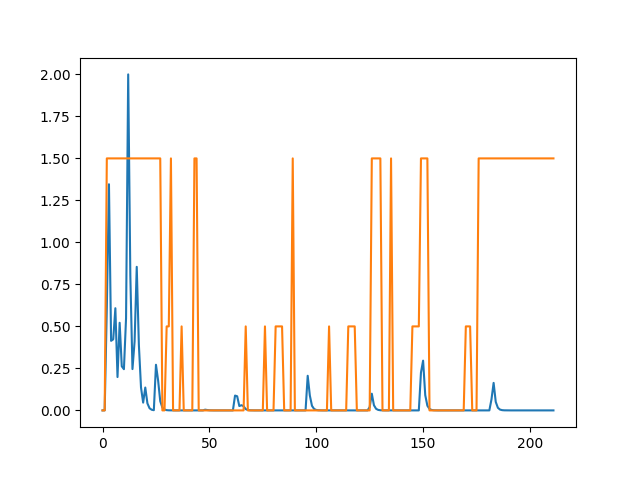

In [47]:
Test2 = C_upd.to_series()
unit = 1
lTest2 = np.array(Test2)[(unit)*rec_dur:(unit+1)*rec_dur]
input_arr = lTest2
R = round(len(lTest2)/(5*list(stamps[0])[2])) # 5 sec bins
split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)
dwnsmpl_subarr = np.split(input_arr, split_arr[1:])
dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )

SleepScoredTSupd2 = SleepScoredTSupd[:len(dwnsmpl_arrT)]
dwnsmpl_arrT2 = 2*dwnsmpl_arrT/max(dwnsmpl_arrT)
dwnsmpl_arrT2 = dwnsmpl_arrT2[0:len(SleepScoredTSupd)]

plt.close()
plt.plot(dwnsmpl_arrT2)
plt.plot(SleepScoredTSupd2)
plt.show()


Distribute Ca2+ intensity to vigilance state

In [48]:
data = {
    'Unit':np.zeros(nb_unit),
    'Wake' : np.zeros(nb_unit),
    'NREM' : np.zeros(nb_unit),
    'N2' : np.zeros(nb_unit),
    'REM' : np.zeros(nb_unit),
}
Activity_state = pd.DataFrame(data, columns=['Unit', 'Wake', 'NREM', 'N2', 'REM'])

for unit in range(nb_unit):
    lTest2 = np.array(Test2)[(unit)*rec_dur:(unit+1)*rec_dur]
    input_arr = lTest2
    R = round(len(lTest2)/(5*list(stamps[0])[2])) # 5 sec bins
    split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)
    dwnsmpl_subarr = np.split(input_arr, split_arr[1:])
    dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )
    dwnsmpl_arrT = dwnsmpl_arrT[0:len(SleepScoredTSupd)]
    for time_stamp in range(len(dwnsmpl_arrT2)):
        if(SleepScoredTSupd2[time_stamp] == 1):
            Activity_state["REM"][unit] = Activity_state["REM"][unit] + dwnsmpl_arrT[time_stamp]    
        elif(SleepScoredTSupd2[time_stamp] == 0.5):
            Activity_state["N2"][unit] = Activity_state["N2"][unit] + dwnsmpl_arrT[time_stamp]     
        elif(SleepScoredTSupd2[time_stamp] == 1.5):
            Activity_state["Wake"][unit] = Activity_state["Wake"][unit] + dwnsmpl_arrT[time_stamp]     
        elif(SleepScoredTSupd2[time_stamp] == 0):
            Activity_state["NREM"][unit] = Activity_state["NREM"][unit] + dwnsmpl_arrT[time_stamp]     


Define how much time (5 sec bin) is spent in each vigilance state

In [49]:
data = {
    'Wake' : np.zeros(2),
    'NREM' : np.zeros(2),
    'N2' : np.zeros(2),
    'REM' : np.zeros(2),
}
Activity_state_time = pd.DataFrame(data, columns=['Wake', 'NREM', 'N2', 'REM'])

for time_stamp in range(len(dwnsmpl_arrT)):
    if(SleepScoredTSupd2[time_stamp] == 1):
        Activity_state_time["REM"][0] = Activity_state_time["REM"][0] + 1   
    elif(SleepScoredTSupd2[time_stamp] == 0.5):
        Activity_state_time["N2"][0] = Activity_state_time["N2"][0] + 1
    elif(SleepScoredTSupd2[time_stamp] == 1.5):
        Activity_state_time["Wake"][0] = Activity_state_time["Wake"][0] + 1    
    elif(SleepScoredTSupd2[time_stamp] == 0):
        Activity_state_time["NREM"][0] = Activity_state_time["NREM"][0] + 1     

Activity_state_time["REM"][1] = Activity_state_time["REM"][0]/len(dwnsmpl_arrT)
Activity_state_time["N2"][1] = Activity_state_time["N2"][0]/len(dwnsmpl_arrT)
Activity_state_time["Wake"][1] = Activity_state_time["Wake"][0]/len(dwnsmpl_arrT)
Activity_state_time["NREM"][1] = Activity_state_time["NREM"][0]/len(dwnsmpl_arrT)
Activity_state_time.index = ['absolu', 'percentage']



Normalise

In [50]:
# Double normalisation 1- by total fluorescence per cell 2- by time spent in each state.
Activity_state_n = Activity_state.copy()
row_sums = Activity_state_n.sum(axis=1)
Activity_state_n = Activity_state_n / row_sums[:, np.newaxis]
# % of fluorescence power observed relative to what would have been expected if intensity was uniformally distributed
RelativeWeight = round(Activity_state_n / Activity_state_time.loc['percentage'] * 100)
RelativeWeight.apply(np.sum, axis=0)/nb_unit

/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_30948/4115522868.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Activity_state_n = Activity_state_n / row_sums[:, np.newaxis]


N2       18.000000
NREM     48.428571
REM       0.000000
Unit      0.000000
Wake    201.000000
dtype: float64

In [51]:
filenameUnit = folder_Minis / f'UnitToKeep.xlsx'
unitname = pd.read_excel(filenameUnit)
RelativeWeight['Unit'] =  unitname[0]

filenameOut = folder_base / f'IntensityNormalisedVigilanceStates.xlsx'
writer = pd.ExcelWriter(filenameOut)
RelativeWeight.to_excel(writer)
writer.save()

Do the same but instead of fluorescence intensity, use active frames

In [52]:
data = {
    'Unit':np.zeros(nb_unit),
    'Wake' : np.zeros(nb_unit),
    'NREM' : np.zeros(nb_unit),
    'N2' : np.zeros(nb_unit),
    'REM' : np.zeros(nb_unit),
}
Activity_state_frame = pd.DataFrame(data, columns=['Unit', 'Wake', 'NREM', 'N2', 'REM'])

for unit in [1,2]:#range(nb_unit):
    lTest2 = np.array(Test2)[(unit)*rec_dur:(unit+1)*rec_dur]
    input_arr = lTest2
    R = round(len(lTest2)/(5*list(stamps[0])[2])) # 5 sec bins
    split_arr = np.linspace(0, len(input_arr), num=R+1, dtype=int)
    dwnsmpl_subarr = np.split(input_arr, split_arr[1:])
    dwnsmpl_arrT = np.array( list( np.mean(item) for item in dwnsmpl_subarr[:-1] ) )
    dwnsmpl_arrT = dwnsmpl_arrT[0:len(SleepScoredTSupd)]
    for time_stamp in range(len(dwnsmpl_arrT)):
        if((SleepScoredTSupd2[time_stamp] == 1) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["REM"][unit] = Activity_state_frame["REM"][unit] + 1    
        elif((SleepScoredTSupd2[time_stamp] == 0.5) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["N2"][unit] = Activity_state_frame["N2"][unit] + 1    
        elif((SleepScoredTSupd2[time_stamp] == 1.5) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["Wake"][unit] = Activity_state_frame["Wake"][unit] + 1     
        elif((SleepScoredTSupd2[time_stamp] == 0) and (dwnsmpl_arrT[time_stamp] > 0)):
            Activity_state_frame["NREM"][unit] = Activity_state_frame["NREM"][unit] + 1     


In [53]:
# Double normalisation 1- by total fluorescence per cell 2- by time spent in each state.
Activity_state_frame_n = Activity_state_frame.copy()
Activity_state_frame_n.apply(np.sum, axis=1)
row_sums_frame = Activity_state_frame_n.sum(axis=1)
Activity_state_frame_n = Activity_state_frame_n / row_sums_frame[:, np.newaxis]
# % of fluorescence power observed relative to what would have been expected if intensity was uniformally distributed
RelativeWeight_frame = round(Activity_state_frame_n / Activity_state_time.loc['percentage'] * 100)

RelativeWeight_frame.apply(np.sum, axis=0)/nb_unit

/var/folders/jq/nz6nvbd54ns2lkjvj31_7_4r0000gn/T/ipykernel_30948/3780239651.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  Activity_state_frame_n = Activity_state_frame_n / row_sums_frame[:, np.newaxis]


N2      13.571429
NREM    35.142857
REM      0.000000
Unit     0.000000
Wake    22.857143
dtype: float64

In [54]:
Activity_state_frame

,Unit,Wake,NREM,N2,REM
0,0.0,0.0,0.0,0.0,0.0
1,0.0,55.0,84.0,6.0,0.0
2,0.0,11.0,43.0,3.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0


In [55]:
filenameOut = folder_base / f'NumFrameNormalisedVigilanceStates.xlsx'
writer = pd.ExcelWriter(filenameOut)
RelativeWeight_frame.to_excel(writer)
writer.save()


In [56]:
Activity_state_time

,Wake,NREM,N2,REM
absolu,76.000000,115.000000,21.000000,0.0
percentage,0.358491,0.542453,0.099057,0.0
